### Evaluation of downsacled CORDEX data

In [1]:
# !pip install --index-url https://test.pypi.org/simple/ cddlt==1.0.13 \
#              --extra-index-url https://pypi.org/simple \
#              cddlt --quiet

In [2]:
import os
import torch
import xclim
import cddlt
import random
import pyproj
import cartopy
import argparse
import torchmetrics

import pandas as pd
import numpy as np
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from cddlt.models.bicubic import Bicubic
from cddlt.models.swinir import SwinIR
from cddlt.models.fno import FNO

from cddlt.dataloaders.downscaling_transform import DownscalingTransform
from cddlt.datasets.rekis_dataset import ReKIS
from cddlt.datasets.cordex_dataset import CORDEX

/home/kostape4/downscale/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/kostape4/downscale/venv/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [3]:
parser = argparse.ArgumentParser()
parser.add_argument("--batch_size", default=32, type=int)
parser.add_argument("--epochs", default=40, type=int)
parser.add_argument("--seed", default=42, type=int)
parser.add_argument("--threads", default=4, type=int)
parser.add_argument("--upscale_factor", default=10, type=int)
parser.add_argument("--lr", default=1e-4, type=float)
parser.add_argument("--logdir", default="logs", type=str)
parser.add_argument("--variables", default=["TM"], type=list)

_StoreAction(option_strings=['--variables'], dest='variables', nargs=None, const=None, default=['TM'], type=<class 'list'>, choices=None, required=False, help=None, metavar=None)

In [4]:
args = parser.parse_args([])
cddlt.startup(args)

In [5]:
REKIS_DATA_PATH = "/mnt/personal/kostape4/data/climate/rekis/"
CORDEX_DATA_PATH = "/mnt/personal/kostape4/data/climate/cordex/"
STATIONS_DATA_PATH = "/mnt/personal/kostape4/data/climate/rekis_stations"
LOGS_PATH = "/home/kostape4/downscale/scripts/logs/"

In [6]:
TIME_SLICE = slice("2003", "2012")

### Data prep

In [7]:
rekis = ReKIS(
    data_path=REKIS_DATA_PATH,
    variables=args.variables,
    train_len=("1961-01-01", "1993-01-01"),
    dev_len=("1993-01-01", "2003-01-01"),
    test_len=("2003-01-01", "2013-01-01"),
    resampling="cubic_spline",
    standardize=True
)

Loading 63 NetCDF file(s)...
Loaded data shape: {'time': 11688, 'northing': 400, 'easting': 400}
Time range: 1961-01-01 00:00:00 to 1992-12-31 00:00:00
Loading 63 NetCDF file(s)...
Loaded data shape: {'time': 3652, 'northing': 400, 'easting': 400}
Time range: 1993-01-01 00:00:00 to 2002-12-31 00:00:00
Loading 63 NetCDF file(s)...
Loaded data shape: {'time': 3653, 'northing': 400, 'easting': 400}
Time range: 2003-01-01 00:00:00 to 2012-12-31 00:00:00

ReKIS dataset initalized.
train size: (11688)
dev size: (3652)
test size: (3653)



In [26]:
rekis_train = DownscalingTransform(dataset=rekis.train).dataloader(args.batch_size)
rekis_dev = DownscalingTransform(dataset=rekis.dev).dataloader(args.batch_size, shuffle=False)
rekis_test = DownscalingTransform(dataset=rekis.test).dataloader(args.batch_size, shuffle=False)

In [8]:
cordex = CORDEX(
    data_path=CORDEX_DATA_PATH,
    variables=args.variables,
    dev_len=("2003-01-01", "2013-01-01"),
    test_len=("2012-01-01", "2013-01-01"),
    standardize=True,
    standard_params=rekis.standard_params
)

Loading 34 NetCDF file(s)...
Loaded data shape: {'time': 3653, 'y': 40, 'x': 40}
Time range: 2003-01-01 12:00:00 to 2012-12-31 12:00:00
Loading 34 NetCDF file(s)...
Loaded data shape: {'time': 366, 'y': 40, 'x': 40}
Time range: 2012-01-01 12:00:00 to 2012-12-31 12:00:00

CORDEX dataset initalized.
dev size: (3653)
test size: (366)



In [9]:
cordex_dev_loader = DownscalingTransform(dataset=cordex.dev).dataloader(args.batch_size, shuffle=False)

#### Stations

In [14]:
stations = (
    pd.read_csv(f"{STATIONS_DATA_PATH}/Stationsliste.txt", index_col="Stat_ID")
)
stations = stations[~stations.index.duplicated(keep='first')]

In [15]:
geometry = gpd.points_from_xy(stations["Laenge"], stations["Breite"], crs="EPSG:4326")
stations = gpd.GeoDataFrame(stations, geometry=geometry)
stations = stations.to_crs(31468)
stations["easting"] = stations.geometry.x
stations["northing"] = stations.geometry.y

In [16]:
geometry = gpd.points_from_xy(stations["Laenge"], stations["Breite"], crs="EPSG:4326")
stations = gpd.GeoDataFrame(stations, geometry=geometry)
stations = stations.to_crs(31468)
stations["easting"] = stations.geometry.x
stations["northing"] = stations.geometry.y
stations = stations.query("4335000.0 <= easting <= 4735000.0 and 5555000.0 <= northing <= 5955000.0")
stations

,Laenge,Breite,Hoehe,Name,geometry,easting,northing
Stat_ID,,,,,,,
DWD_12,10.186000,52.381000,61.0,Abbensen,POINT (4376587.138 5806843.945),4.376587e+06,5.806844e+06
DWD_13,11.289000,51.615000,300.0,Abberode,POINT (4450857.049 5720304.152),4.450857e+06,5.720304e+06
DWD_26,10.054000,52.550000,41.0,Adelheidsdorf,POINT (4368106.418 5825880.477),4.368106e+06,5.825880e+06
DWD_31,10.433000,53.283000,25.0,Adendorf,POINT (4395591.283 5906818.623),4.395591e+06,5.906819e+06
DWD_32,9.933000,52.000000,194.0,Adenstedt,POINT (4358153.726 5764918.45),4.358154e+06,5.764918e+06
...,...,...,...,...,...,...,...
CZ_U7CEJI01,13.586900,50.687800,740.0,Èeský Jiřetín,POINT (4612246.237 5618115.479),4.612246e+06,5.618115e+06
CZ_U7HEJN01,15.182800,50.885000,397.0,Hejnice,POINT (4724058.88 5643681.138),4.724059e+06,5.643681e+06
CZ_U7KAME01,13.331023,50.513314,590.0,"VD Kamenièka, přehrada",POINT (4594513.756 5598349.969),4.594514e+06,5.598350e+06


In [17]:
measurements = (
    pd.read_csv(
        "/mnt/personal/kostape4/data/climate/rekis_stations/TM.csv",
        decimal=",",
        sep=";",
        index_col=["zeit"],
        parse_dates=True,
    )
    .loc[TIME_SLICE]
    .reset_index()
    .melt(value_name="TM", id_vars="zeit", var_name="Stat_ID")
    .sort_values(["Stat_ID", "zeit"])
    .set_index("Stat_ID")
    .join(stations, how="inner")
)
measurements

,zeit,TM,Laenge,Breite,Hoehe,Name,geometry,easting,northing
Stat_ID,,,,,,,,,
CZ_H3PODE01,2003-01-01 00:00:00+00:00,-6.8,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06
CZ_H3PODE01,2003-01-02 00:00:00+00:00,5.3,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06
CZ_H3PODE01,2003-01-03 00:00:00+00:00,6.4,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06
CZ_H3PODE01,2003-01-04 00:00:00+00:00,0.6,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06
CZ_H3PODE01,2003-01-05 00:00:00+00:00,-5.0,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06
...,...,...,...,...,...,...,...,...,...
PL_5101,2012-12-27 00:00:00+00:00,4.5,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06
PL_5101,2012-12-28 00:00:00+00:00,-0.8,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06
PL_5101,2012-12-29 00:00:00+00:00,1.6,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06


#### ReKIS

In [18]:
std_rekis_test = rekis.test.targets
rekis_test = rekis.destandardize([std_rekis_test])[0]
rekis_test.shape

torch.Size([3653, 1, 400, 400])

In [19]:
rekis_test = xr.DataArray(
    rekis_test.squeeze(),
    dims=("time", "northing", "easting"),
    coords={
        "time": rekis.test.dataset.coords["time"],
        "northing": rekis.test.dataset.coords["northing"],
        "easting": rekis.test.dataset.coords["easting"],
        "crs": rekis.test.dataset.coords["crs"],
    },
    attrs=rekis.test.dataset.attrs
)

In [20]:
measurements["rekis"] = rekis_test.sel(
    time=xr.DataArray(measurements["zeit"]),
    easting=xr.DataArray(measurements["easting"]),
    northing=xr.DataArray(measurements["northing"]),
    method="nearest",
)
measurements

,zeit,TM,Laenge,Breite,Hoehe,Name,geometry,easting,northing,rekis
Stat_ID,,,,,,,,,,
CZ_H3PODE01,2003-01-01 00:00:00+00:00,-6.8,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,-7.3
CZ_H3PODE01,2003-01-02 00:00:00+00:00,5.3,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,5.4
CZ_H3PODE01,2003-01-03 00:00:00+00:00,6.4,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,6.5
CZ_H3PODE01,2003-01-04 00:00:00+00:00,0.6,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,0.4
CZ_H3PODE01,2003-01-05 00:00:00+00:00,-5.0,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,-4.9
...,...,...,...,...,...,...,...,...,...,...
PL_5101,2012-12-27 00:00:00+00:00,4.5,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06,2.9
PL_5101,2012-12-28 00:00:00+00:00,-0.8,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06,-2.9
PL_5101,2012-12-29 00:00:00+00:00,1.6,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06,1.9


#### CORDEX

In [21]:
cordex_orig = xr.open_mfdataset(
    "/mnt/data/climate/CORDEX/tas/tas_EUR-11_ECMWF-ERAINT_evaluation_r1i1p1_GERICS-REMO2015_v1_day_*.nc",
    decode_coords="all",
)
cordex_orig = cordex_orig["tas"].sel(time=TIME_SLICE)
cordex_orig["time"] = cordex_orig["time"].dt.floor(freq="D")
transformer = pyproj.Transformer.from_crs("EPSG:4326", cordex_orig.rio.crs, always_xy=True)
rlon, rlat = transformer.transform(measurements["Laenge"], measurements["Breite"])
measurements["rlon"] = rlon
measurements["rlat"] = rlat
measurements["cordex"] = cordex_orig.sel(
    time=xr.DataArray(measurements["zeit"]),
    rlon=xr.DataArray(measurements["rlon"]),
    rlat=xr.DataArray(measurements["rlat"]),
    method="nearest",
)
measurements["cordex"] -= 273.15
measurements

,zeit,TM,Laenge,Breite,Hoehe,Name,geometry,easting,northing,rekis,rlon,rlat,cordex
Stat_ID,,,,,,,,,,,,,
CZ_H3PODE01,2003-01-01 00:00:00+00:00,-6.8,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,-7.3,-1.849871,-0.568605,0.523987
CZ_H3PODE01,2003-01-02 00:00:00+00:00,5.3,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,5.4,-1.849871,-0.568605,6.027771
CZ_H3PODE01,2003-01-03 00:00:00+00:00,6.4,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,6.5,-1.849871,-0.568605,4.790710
CZ_H3PODE01,2003-01-04 00:00:00+00:00,0.6,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,0.4,-1.849871,-0.568605,3.437225
CZ_H3PODE01,2003-01-05 00:00:00+00:00,-5.0,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,-4.9,-1.849871,-0.568605,0.083862
...,...,...,...,...,...,...,...,...,...,...,...,...,...
PL_5101,2012-12-27 00:00:00+00:00,4.5,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06,2.9,-1.681445,0.180302,-1.923218
PL_5101,2012-12-28 00:00:00+00:00,-0.8,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06,-2.9,-1.681445,0.180302,-3.308990
PL_5101,2012-12-29 00:00:00+00:00,1.6,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06,1.9,-1.681445,0.180302,-2.479401


#### Bicubic

In [22]:
bicubic = Bicubic(
    upscale_factor=args.upscale_factor,
    mode="bicubic"
)

In [23]:
bicubic.configure(
    optimizer = None,
    scheduler = None,
    loss = torchmetrics.MeanSquaredError(squared=True),
    metrics={
        "mse": torchmetrics.MeanSquaredError(squared=False),
        "rmse": torchmetrics.MeanSquaredError(squared=True),
        "mae": torchmetrics.MeanAbsoluteError(),
        "psnr": torchmetrics.image.PeakSignalNoiseRatio(),
    },
    args = args
)

Bicubic(
  (loss): MeanSquaredError()
)

In [27]:
bicubic.evaluate(rekis_dev, print_loss=True)

dev_mse: 0.0339, dev_rmse: 0.0012, dev_mae: 0.0199, dev_psnr: 45.8139
Evaluation - dev_loss: 0.001146


In [28]:
bicubic_cordex = bicubic.predict(cordex_dev_loader)
bicubic_cordex = torch.cat(bicubic_cordex, dim=0)
bicubic_cordex = rekis.destandardize([bicubic_cordex.cpu()])[0]
bicubic_cordex.shape

torch.Size([3653, 1, 400, 400])

In [29]:
bicubic_xr = xr.DataArray(
    bicubic_cordex.squeeze(),
    dims=("time", "northing", "easting"),
    coords={
        "time": rekis.test.dataset.coords["time"],
        "northing": rekis.test.dataset.coords["northing"],
        "easting": rekis.test.dataset.coords["easting"],
        "crs": rekis.test.dataset.coords["crs"],
    },
    attrs=rekis.test.dataset.attrs
)

In [30]:
measurements["bicubic"] = bicubic_xr.sel(
    time=xr.DataArray(measurements["zeit"]),
    easting=xr.DataArray(measurements["easting"]),
    northing=xr.DataArray(measurements["northing"]),
    method="nearest",
)
measurements

,zeit,TM,Laenge,Breite,Hoehe,Name,geometry,easting,northing,rekis,rlon,rlat,cordex,bicubic
Stat_ID,,,,,,,,,,,,,,
CZ_H3PODE01,2003-01-01 00:00:00+00:00,-6.8,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,-7.3,-1.849871,-0.568605,0.523987,0.348615
CZ_H3PODE01,2003-01-02 00:00:00+00:00,5.3,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,5.4,-1.849871,-0.568605,6.027771,5.403883
CZ_H3PODE01,2003-01-03 00:00:00+00:00,6.4,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,6.5,-1.849871,-0.568605,4.790710,4.422959
CZ_H3PODE01,2003-01-04 00:00:00+00:00,0.6,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,0.4,-1.849871,-0.568605,3.437225,2.906554
CZ_H3PODE01,2003-01-05 00:00:00+00:00,-5.0,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,-4.9,-1.849871,-0.568605,0.083862,-0.111014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PL_5101,2012-12-27 00:00:00+00:00,4.5,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06,2.9,-1.681445,0.180302,-1.923218,-1.240854
PL_5101,2012-12-28 00:00:00+00:00,-0.8,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06,-2.9,-1.681445,0.180302,-3.308990,-2.615664
PL_5101,2012-12-29 00:00:00+00:00,1.6,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06,1.9,-1.681445,0.180302,-2.479401,-1.986635


In [31]:
random.seed(27)
i = random.randint(0, bicubic_cordex.shape[0])

In [32]:
def plot_lr_sr(cordex: cddlt.datasets.cordex_dataset.CORDEX, pred: torch.Tensor) -> None:
    destd_cordex_dev = rekis.destandardize([cordex.dev.inputs.cpu()])[0].squeeze()
    comb = torch.cat(
        [destd_cordex_dev[i].flatten(), pred[i].flatten()],
    )
    
    vmin, vmax = torch.min(comb), torch.max(comb)
    norm = Normalize(vmin=vmin, vmax=vmax)

    fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
    axes[0].set_title("LR")
    im1 = axes[0].imshow(destd_cordex_dev[i, ...], norm=norm)
    
    axes[1].set_title("SR")
    im2 = axes[1].imshow(pred.squeeze()[i, ...], norm=norm)
    
    cbar = fig.colorbar(im2, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label("°C")
    plt.show()

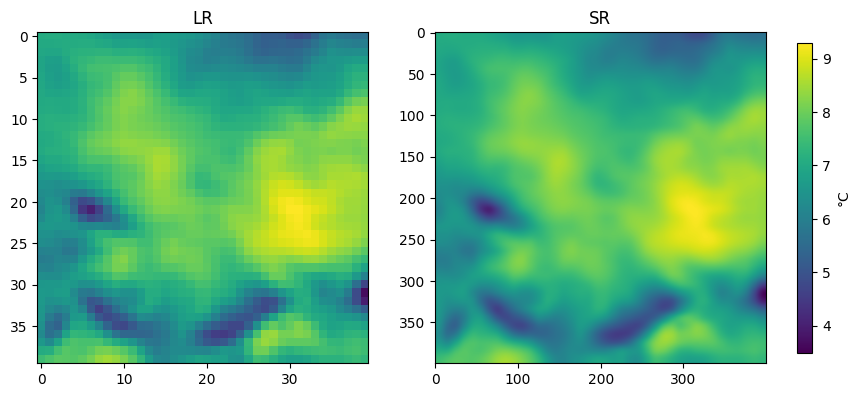

In [33]:
plot_lr_sr(cordex, bicubic_cordex)

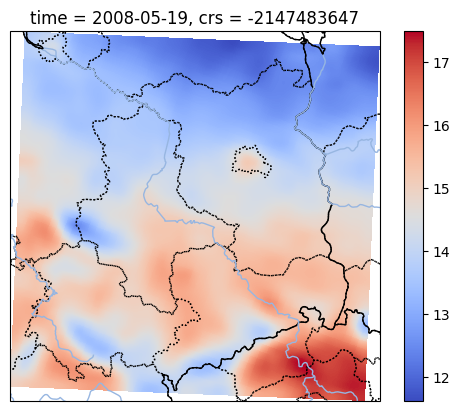

In [34]:
fig, ax = plt.subplots(subplot_kw={"projection": cartopy.crs.UTM(33)})
i = random.randint(0, len(bicubic_xr.time) - 1)
bicubic_xr.isel(time=i).plot(
    ax=ax,
    transform=cartopy.crs.epsg(rekis.test.dataset.coords["crs"].attrs["epsg_code"]),
    # center=0,
    cmap="coolwarm",
)
ax.add_feature(cartopy.feature.BORDERS)
ax.add_feature(cartopy.feature.STATES, linestyle=":")
ax.add_feature(cartopy.feature.RIVERS)
ax.add_feature(cartopy.feature.COASTLINE)

#### Bilinear

In [35]:
bilinear = Bicubic(
    upscale_factor=args.upscale_factor,
    mode="bilinear"
)

In [36]:
bilinear.configure(
    optimizer = None,
    scheduler = None,
    loss = torchmetrics.MeanSquaredError(squared=True),
    metrics={
        "mse": torchmetrics.MeanSquaredError(squared=False),
        "rmse": torchmetrics.MeanSquaredError(squared=True),
        "mae": torchmetrics.MeanAbsoluteError(),
        "psnr": torchmetrics.image.PeakSignalNoiseRatio(),
    },
    args = args
)

Bicubic(
  (loss): MeanSquaredError()
)

In [37]:
bilinear.evaluate(rekis_dev, print_loss=True)

dev_mse: 0.0358, dev_rmse: 0.0013, dev_mae: 0.0210, dev_psnr: 45.3460
Evaluation - dev_loss: 0.001276


In [38]:
bilinear_cordex = bilinear.predict(cordex_dev_loader)
bilinear_cordex = torch.cat(bilinear_cordex, dim=0)
bilinear_cordex = rekis.destandardize([bilinear_cordex.cpu()])[0]
bilinear_cordex.shape

torch.Size([3653, 1, 400, 400])

In [39]:
bilinear_xr = xr.DataArray(
    bilinear_cordex.squeeze(),
    dims=("time", "northing", "easting"),
    coords={
        "time": rekis.test.dataset.coords["time"],
        "northing": rekis.test.dataset.coords["northing"],
        "easting": rekis.test.dataset.coords["easting"],
        "crs": rekis.test.dataset.coords["crs"],
    },
    attrs=rekis.test.dataset.attrs
)

In [40]:
measurements["bilinear"] = bilinear_xr.sel(
    time=xr.DataArray(measurements["zeit"]),
    easting=xr.DataArray(measurements["easting"]),
    northing=xr.DataArray(measurements["northing"]),
    method="nearest",
)
measurements

,zeit,TM,Laenge,Breite,Hoehe,Name,geometry,easting,northing,rekis,rlon,rlat,cordex,bicubic,bilinear
Stat_ID,,,,,,,,,,,,,,,
CZ_H3PODE01,2003-01-01 00:00:00+00:00,-6.8,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,-7.3,-1.849871,-0.568605,0.523987,0.348615,0.334984
CZ_H3PODE01,2003-01-02 00:00:00+00:00,5.3,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,5.4,-1.849871,-0.568605,6.027771,5.403883,5.356041
CZ_H3PODE01,2003-01-03 00:00:00+00:00,6.4,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,6.5,-1.849871,-0.568605,4.790710,4.422959,4.400250
CZ_H3PODE01,2003-01-04 00:00:00+00:00,0.6,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,0.4,-1.849871,-0.568605,3.437225,2.906554,2.878432
CZ_H3PODE01,2003-01-05 00:00:00+00:00,-5.0,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,-4.9,-1.849871,-0.568605,0.083862,-0.111014,-0.120951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PL_5101,2012-12-27 00:00:00+00:00,4.5,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06,2.9,-1.681445,0.180302,-1.923218,-1.240854,-1.139339
PL_5101,2012-12-28 00:00:00+00:00,-0.8,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06,-2.9,-1.681445,0.180302,-3.308990,-2.615664,-2.528644
PL_5101,2012-12-29 00:00:00+00:00,1.6,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06,1.9,-1.681445,0.180302,-2.479401,-1.986635,-1.953296


#### EDSR

In [41]:
...

Ellipsis

#### FNO

In [42]:
fno = FNO(
    n_channels=1,
    upscale_factor=args.upscale_factor,
    layers=7,
    width=64,
    modes1=14,
    modes2=14
)

In [88]:
fno.configure(
    optimizer = None,
    scheduler = None,
    loss = torchmetrics.MeanSquaredError(squared=True),
    metrics={
        "mse": torchmetrics.MeanSquaredError(squared=False),
        "rmse": torchmetrics.MeanSquaredError(squared=True),
        "mae": torchmetrics.MeanAbsoluteError(),
        "psnr": torchmetrics.image.PeakSignalNoiseRatio(),
    },
    args = args
);

In [44]:
fno.load_weights(os.path.join(LOGS_PATH, fno.model_name))
fno.evaluate(rekis_dev, print_loss=True)

dev_mse: 0.0095, dev_rmse: 0.0001, dev_mae: 0.0065, dev_psnr: 56.8532
Evaluation - dev_loss: 9.072e-05


In [45]:
fno.eval()
y_preds = []
for x, _ in cordex_dev_loader:
    x = x.to(fno.device)
    y_pred = fno.predict_step(x)
    y_preds.append(y_pred)

In [46]:
std_fno_cordex = torch.cat(y_preds, dim=0)   
fno_cordex = rekis.destandardize([std_fno_cordex.cpu()])[0]
fno_cordex.shape

torch.Size([3653, 1, 400, 400])

In [47]:
fno_cordex_xr = xr.DataArray(
    fno_cordex.squeeze(),
    dims=("time", "northing", "easting"),
    coords={
        "time": rekis.test.dataset.coords["time"],
        "northing": rekis.test.dataset.coords["northing"],
        "easting": rekis.test.dataset.coords["easting"],
        "crs": rekis.test.dataset.coords["crs"],
    },
    attrs=rekis.test.dataset.attrs
)

In [48]:
measurements["fno"] = fno_cordex_xr.sel(
    time=xr.DataArray(measurements["zeit"]),
    easting=xr.DataArray(measurements["easting"]),
    northing=xr.DataArray(measurements["northing"]),
    method="nearest",
)
measurements

,zeit,TM,Laenge,Breite,Hoehe,Name,geometry,easting,northing,rekis,rlon,rlat,cordex,bicubic,bilinear,fno
Stat_ID,,,,,,,,,,,,,,,,
CZ_H3PODE01,2003-01-01 00:00:00+00:00,-6.8,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,-7.3,-1.849871,-0.568605,0.523987,0.348615,0.334984,0.241669
CZ_H3PODE01,2003-01-02 00:00:00+00:00,5.3,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,5.4,-1.849871,-0.568605,6.027771,5.403883,5.356041,5.727620
CZ_H3PODE01,2003-01-03 00:00:00+00:00,6.4,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,6.5,-1.849871,-0.568605,4.790710,4.422959,4.400250,4.578108
CZ_H3PODE01,2003-01-04 00:00:00+00:00,0.6,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,0.4,-1.849871,-0.568605,3.437225,2.906554,2.878432,2.972604
CZ_H3PODE01,2003-01-05 00:00:00+00:00,-5.0,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,-4.9,-1.849871,-0.568605,0.083862,-0.111014,-0.120951,-0.226392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PL_5101,2012-12-27 00:00:00+00:00,4.5,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06,2.9,-1.681445,0.180302,-1.923218,-1.240854,-1.139339,-0.916223
PL_5101,2012-12-28 00:00:00+00:00,-0.8,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06,-2.9,-1.681445,0.180302,-3.308990,-2.615664,-2.528644,-2.364359
PL_5101,2012-12-29 00:00:00+00:00,1.6,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06,1.9,-1.681445,0.180302,-2.479401,-1.986635,-1.953296,-1.385214


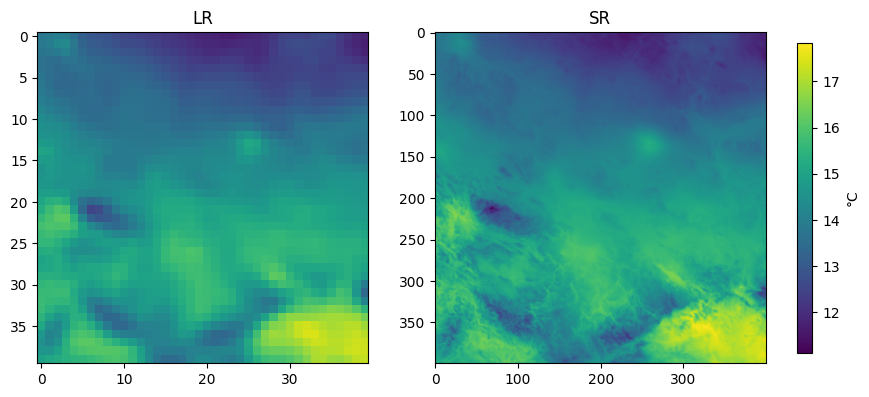

In [49]:
plot_lr_sr(cordex, fno_cordex)

In [52]:
#fno_cordex_xr.to_netcdf("./data/fno_cordex.nc")

#### SWIN

In [53]:
stl = 6
rstb = 6
att_head_nr = 6

In [54]:
depths = [stl for _ in range(rstb)]
num_heads = [att_head_nr for _ in range(rstb)]

In [55]:
swin = SwinIR(
    img_size=40,
    in_chans=len(args.variables),
    window_size=8,
    embed_dim=180,
    depths=depths,
    num_heads=num_heads,
    upsampler="pixelshuffle",
    upscale=args.upscale_factor
)

/home/kostape4/downscale/venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [89]:
swin.configure(
    optimizer = None,
    scheduler = None,
    loss = torch.nn.L1Loss(),
    metrics={
        "mse": torchmetrics.MeanSquaredError(squared=True),
        "rmse": torchmetrics.MeanSquaredError(squared=False),
        "mae": torchmetrics.MeanAbsoluteError(),
        "psnr": torchmetrics.image.PeakSignalNoiseRatio(),
    },
    args = args,
);

In [57]:
swin.load_weights(os.path.join(LOGS_PATH, swin.model_name))
swin.evaluate(rekis_dev, print_loss=True)

dev_mse: 0.0000, dev_rmse: 0.0044, dev_mae: 0.0036, dev_psnr: 63.5609
Evaluation - dev_loss: 0.003564


In [64]:
swin.eval()
y_preds = []
for x, _ in cordex_dev_loader:
    x = x.to(swin.device)
    y_pred = swin.predict_step(x)
    y_preds.append(y_pred)

In [65]:
std_swin_cordex = torch.cat(y_preds, dim=0)   
swin_cordex = rekis.destandardize([std_swin_cordex.cpu()])[0]
swin_cordex.shape

torch.Size([3653, 1, 400, 400])

In [66]:
swin_cordex_xr = xr.DataArray(
    swin_cordex.squeeze(),
    dims=("time", "northing", "easting"),
    coords={
        "time": rekis.test.dataset.coords["time"],
        "northing": rekis.test.dataset.coords["northing"],
        "easting": rekis.test.dataset.coords["easting"],
        "crs": rekis.test.dataset.coords["crs"],
    },
    attrs=rekis.test.dataset.attrs
)

In [67]:
measurements["swin"] = swin_cordex_xr.sel(
    time=xr.DataArray(measurements["zeit"]),
    easting=xr.DataArray(measurements["easting"]),
    northing=xr.DataArray(measurements["northing"]),
    method="nearest",
)
measurements

,zeit,TM,Laenge,Breite,Hoehe,Name,geometry,easting,northing,rekis,rlon,rlat,cordex,bicubic,bilinear,fno,swin
Stat_ID,,,,,,,,,,,,,,,,,
CZ_H3PODE01,2003-01-01 00:00:00+00:00,-6.8,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,-7.3,-1.849871,-0.568605,0.523987,0.348615,0.334984,0.241669,0.392414
CZ_H3PODE01,2003-01-02 00:00:00+00:00,5.3,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,5.4,-1.849871,-0.568605,6.027771,5.403883,5.356041,5.727620,5.592207
CZ_H3PODE01,2003-01-03 00:00:00+00:00,6.4,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,6.5,-1.849871,-0.568605,4.790710,4.422959,4.400250,4.578108,4.525563
CZ_H3PODE01,2003-01-04 00:00:00+00:00,0.6,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,0.4,-1.849871,-0.568605,3.437225,2.906554,2.878432,2.972604,3.024010
CZ_H3PODE01,2003-01-05 00:00:00+00:00,-5.0,15.112800,50.1453,196.0,Podìbrady,POINT (4722587.778 5561210.642),4.722588e+06,5.561211e+06,-4.9,-1.849871,-0.568605,0.083862,-0.111014,-0.120951,-0.226392,-0.091828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PL_5101,2012-12-27 00:00:00+00:00,4.5,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06,2.9,-1.681445,0.180302,-1.923218,-1.240854,-1.139339,-0.916223,-1.390291
PL_5101,2012-12-28 00:00:00+00:00,-0.8,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06,-2.9,-1.681445,0.180302,-3.308990,-2.615664,-2.528644,-2.364359,-3.668301
PL_5101,2012-12-29 00:00:00+00:00,1.6,15.333333,50.9000,754.0,ŚWIERADÓW-ZDRÓJ,POINT (4734573.178 5645817.076),4.734573e+06,5.645817e+06,1.9,-1.681445,0.180302,-2.479401,-1.986635,-1.953296,-1.385214,-1.730573


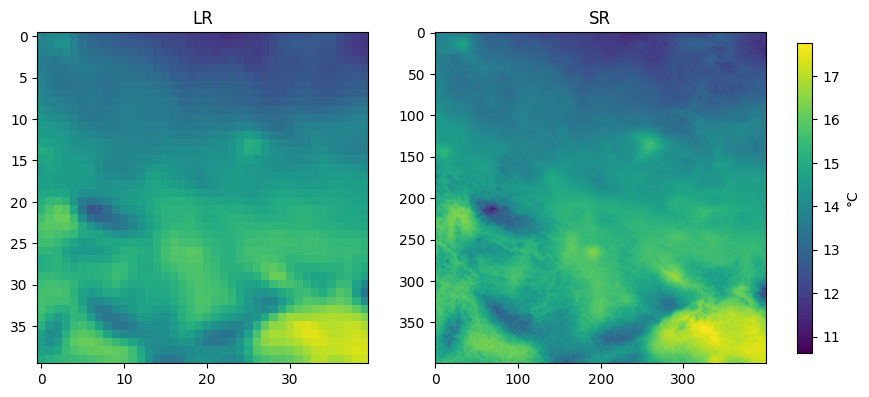

In [68]:
plot_lr_sr(cordex, swin_cordex)

In [69]:
#swin_cordex_xr.to_netcdf("./data/swin_cordex.nc")

### Evaluation

In [70]:
#measurements.to_csv("measurements.csv")

In [71]:
measurements = pd.read_csv("measurements.csv")
measurements["zeit"] = pd.to_datetime(measurements["zeit"].values).tz_localize(None)
measurements = (
    measurements.rename(columns={"zeit": "time"})
    .set_index(["Stat_ID", "time"])
)

In [72]:
measurements_xr = measurements.to_xarray()
tvars = ["TM", "rekis", "cordex", "bicubic", "bilinear", "fno", "swin"]
for pred in tvars:
    measurements_xr[pred].attrs["standard_name"] = "air_temperature"
    measurements_xr[pred].attrs["cell_methods"] = "time: mean"
    measurements_xr[pred].attrs["units"] = "degC"

measurements_xr

<xarray.Dataset> Size: 188MB
Dimensions:   (Stat_ID: 403, time: 3653)
Coordinates:
  * Stat_ID   (Stat_ID) object 3kB 'CZ_H3PODE01' 'CZ_L2HERM01' ... 'PL_5101'
  * time      (time) datetime64[ns] 29kB 2003-01-01 2003-01-02 ... 2012-12-31
Data variables: (12/16)
    TM        (Stat_ID, time) float64 12MB -6.8 5.3 6.4 0.6 ... -0.8 1.6 1.4 3.1
    Laenge    (Stat_ID, time) float64 12MB 15.11 15.11 15.11 ... 15.33 15.33
    Breite    (Stat_ID, time) float64 12MB 50.15 50.15 50.15 ... 50.9 50.9 50.9
    Hoehe     (Stat_ID, time) float64 12MB 196.0 196.0 196.0 ... 754.0 754.0
    Name      (Stat_ID, time) object 12MB 'Podìbrady' ... 'ŚWIERADÓW-ZDRÓJ'
    geometry  (Stat_ID, time) object 12MB 'POINT (4722587.777732876 5561210.6...
    ...        ...
    rlat      (Stat_ID, time) float64 12MB -0.5686 -0.5686 ... 0.1803 0.1803
    cordex    (Stat_ID, time) float64 12MB 0.524 6.028 4.791 ... 0.9814 0.3423
    bicubic   (Stat_ID, time) float64 12MB 0.3486 5.404 4.423 ... 0.9696 0.963
    bilinear  (Stat_ID, time) float64 12MB 0.335 5.356 4.4 ... 0.9663 1.029
    fno       (Stat_ID, time) float64 12MB 0.2417 5.728 4.578 ... 1.548 1.439
    swin      (Stat_ID, time) float64 12MB 0.3924 5.592 4.526 ... 1.556 1.047

In [73]:
models = tvars.copy()
models.remove("TM")

#### Daily mean temperature (year, DJF, JJA)

In [74]:
def calc_daily_mean_tm(x: xr.Dataset, pred: str = "rekis", group: str = "year", ref: str = "TM") -> float:
    if group == "year":
        y = xclim.indices.tg_mean(x[ref], freq="YS")
        y_hat = xclim.indices.tg_mean(x[pred], freq="YS")
    else:
        y = xclim.indices.tg_mean(x[ref], freq="QS-DEC")
        y_hat = xclim.indices.tg_mean(x[pred], freq="QS-DEC")
        
        offset = None if group == "djf" else 2
        y = y.isel(time=slice(offset, None, 4))
        y_hat = y_hat.isel(time=slice(offset, None, 4))

    return np.sqrt(((y - y_hat) ** 2).mean().values)

In [75]:
print(f"yearly agg:")
for pred in models:
    print(f"{pred}: {calc_daily_mean_tm(measurements_xr, pred, "year"):.3f}")

yearly agg:
rekis: 0.295
cordex: 0.877
bicubic: 0.866
bilinear: 0.883
fno: 0.765
swin: 0.758


In [76]:
# xclim.indices.tg_mean agg also includes trailing months like first january and february
print(f"djf agg:")
for pred in models:
    print(f"{pred}: {calc_daily_mean_tm(measurements_xr, pred, "djf"):.3f}")

djf agg:
rekis: 0.258
cordex: 1.752
bicubic: 1.746
bilinear: 1.751
fno: 1.698
swin: 1.688


In [77]:
print(f"jja agg:")
for pred in models:
    print(f"{pred}: {calc_daily_mean_tm(measurements_xr, pred, "jja"):.3f}")

jja agg:
rekis: 0.381
cordex: 1.406
bicubic: 1.393
bilinear: 1.405
fno: 1.332
swin: 1.333


#### Degree days (growing, cooling, heating)

In [84]:
# thresh values from: 
# https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2019JD032344
def calc_degree_days(ds: xr.Dataset, metric: str = "growing", pred: str="rekis", tas: str="TM", freq: str="YS") -> float:
    if metric == "growing":
        y = xclim.indicators.atmos.growing_degree_days(tas=tas, thresh="5 degC", freq=freq, ds=ds)
        y_hat = xclim.indicators.atmos.growing_degree_days(tas=pred, thresh="5 degC", freq=freq, ds=ds)
    elif metric == "cooling":
        y = xclim.indicators.atmos.cooling_degree_days(tas=tas, thresh="22 degC", freq=freq, ds=ds)
        y_hat = xclim.indicators.atmos.cooling_degree_days(tas=pred, thresh="22 degC", freq=freq, ds=ds)
    elif metric == "heating":
        y = xclim.indicators.atmos.heating_degree_days(tas=tas, thresh="15.5 degC", freq=freq, ds=ds)
        y_hat = xclim.indicators.atmos.heating_degree_days(tas=pred, thresh="15.5 degC", freq=freq, ds=ds)

    return np.sqrt(((y - y_hat) ** 2).mean().values)

In [85]:
print(f"growing degree days:")
for pred in models:
    print(f"{pred}: {calc_degree_days(measurements_xr, metric="growing", pred=pred):.3f}")

growing degree days:
rekis: 80.768
cordex: 258.575
bicubic: 253.687
bilinear: 256.765
fno: 241.088
swin: 239.884


#### Cooling degree days

In [86]:
print(f"cooling degree days:")
for pred in models:
    print(f"{pred}: {calc_degree_days(measurements_xr, metric="cooling", pred=pred):.3f}")

cooling degree days:
rekis: 7.648
cordex: 31.302
bicubic: 30.344
bilinear: 30.234
fno: 30.633
swin: 31.058


#### Heating degree days

In [87]:
print(f"heating degree days:")
for pred in models:
    print(f"{pred}: {calc_degree_days(measurements_xr, metric="heating", pred=pred):.3f}")

heating degree days:
rekis: 78.053
cordex: 260.999
bicubic: 260.301
bilinear: 265.376
fno: 226.429
swin: 223.239
